In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F


In [3]:
!pip install torchinfo
from torchinfo import summary


In [4]:
!unzip /kaggle/input/denoising-dirty-documents/train.zip -d /content/denoising_data
!unzip /kaggle/input/denoising-dirty-documents/test.zip -d /content/denoising_data
!unzip /kaggle/input/denoising-dirty-documents/train_cleaned.zip -d /content/denoising_data


Archive:  /kaggle/input/denoising-dirty-documents/train.zip
   creating: /content/denoising_data/train/
  inflating: /content/denoising_data/train/116.png  
  inflating: /content/denoising_data/train/201.png  
  inflating: /content/denoising_data/train/206.png  
  inflating: /content/denoising_data/train/96.png  
  inflating: /content/denoising_data/train/47.png  
  inflating: /content/denoising_data/train/98.png  
  inflating: /content/denoising_data/train/164.png  
  inflating: /content/denoising_data/train/32.png  
  inflating: /content/denoising_data/train/156.png  
  inflating: /content/denoising_data/train/72.png  
  inflating: /content/denoising_data/train/189.png  
  inflating: /content/denoising_data/train/158.png  
  inflating: /content/denoising_data/train/75.png  
  inflating: /content/denoising_data/train/123.png  
  inflating: /content/denoising_data/train/132.png  
  inflating: /content/denoising_data/train/18.png  
  inflating: /content/denoising_data/train/135.png  
  

In [5]:
# 이미지 디렉토리
train_dir = "/content/denoising_data/train"
train_cleaned_dir = "/content/denoising_data/train_cleaned"
test_dir = "/content/denoising_data/test"


In [6]:
# 폴더에서 이미지 가져오기 함수
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):   # PNG파일 로드
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)  # OpenCV로 이미지 읽기(BGR형식)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
            images.append(img)
    return images


In [7]:
# 이미지 불러오기
train_images = load_images_from_folder(train_dir)
train_cleaned_images = load_images_from_folder(train_cleaned_dir)
test_images = load_images_from_folder(test_dir)


In [8]:
# 결과 출력
print(f"train_images: {len(train_images)}")
print(f"train_cleaned_images: {len(train_cleaned_images)}")
print(f"test_images: {len(test_images)}")


train_images: 115
train_cleaned_images: 115
test_images: 29


In [9]:
train_images[0]


array([[[225, 225, 225],
        [227, 227, 227],
        [232, 232, 232],
        ...,
        [222, 222, 222],
        [220, 220, 220],
        [217, 217, 217]],

       [[224, 224, 224],
        [224, 224, 224],
        [225, 225, 225],
        ...,
        [225, 225, 225],
        [220, 220, 220],
        [211, 211, 211]],

       [[234, 234, 234],
        [233, 233, 233],
        [228, 228, 228],
        ...,
        [224, 224, 224],
        [223, 223, 223],
        [218, 218, 218]],

       ...,

       [[220, 220, 220],
        [227, 227, 227],
        [230, 230, 230],
        ...,
        [203, 203, 203],
        [202, 202, 202],
        [214, 214, 214]],

       [[221, 221, 221],
        [227, 227, 227],
        [232, 232, 232],
        ...,
        [223, 223, 223],
        [221, 221, 221],
        [213, 213, 213]],

       [[225, 225, 225],
        [227, 227, 227],
        [227, 227, 227],
        ...,
        [216, 216, 216],
        [216, 216, 216],
        [214, 214, 214]]

In [10]:
train_cleaned_images[0]


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [248, 248, 248],
        [249, 249, 249],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [253, 253, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]]

In [11]:
test_images[0]


array([[[228, 228, 228],
        [228, 228, 228],
        [227, 227, 227],
        ...,
        [227, 227, 227],
        [227, 227, 227],
        [230, 230, 230]],

       [[225, 225, 225],
        [230, 230, 230],
        [231, 231, 231],
        ...,
        [229, 229, 229],
        [228, 228, 228],
        [227, 227, 227]],

       [[229, 229, 229],
        [234, 234, 234],
        [225, 225, 225],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [224, 224, 224]],

       ...,

       [[231, 231, 231],
        [228, 228, 228],
        [230, 230, 230],
        ...,
        [134, 134, 134],
        [127, 127, 127],
        [138, 138, 138]],

       [[235, 235, 235],
        [228, 228, 228],
        [229, 229, 229],
        ...,
        [140, 140, 140],
        [135, 135, 135],
        [152, 152, 152]],

       [[236, 236, 236],
        [228, 228, 228],
        [226, 226, 226],
        ...,
        [ 82,  82,  82],
        [ 97,  97,  97],
        [139, 139, 139]]

In [12]:
# 각 데이터셋의 이미지 크기 추출
train_sizes = [img.shape[:2] for img in train_images]
train_cleaned_sizes = [img.shape[:2] for img in train_cleaned_images]
test_sizes = [img.shape[:2] for img in test_images]


In [13]:
# 유니크 이미지 크기
unique_train_sizes = np.unique(train_sizes, axis=0)
unique_train_cleaned_sizes = np.unique(train_cleaned_sizes, axis=0)
unique_test_sizes = np.unique(test_sizes, axis=0)


In [14]:
# 결과 출력
print(f"train_images:\n {unique_train_sizes}")
print(f"train_cleaned_images:\n {unique_train_cleaned_sizes}")
print(f"test_images:\n {unique_test_sizes}")


train_images:
 [[258 540]
 [420 540]]
train_cleaned_images:
 [[258 540]
 [420 540]]
test_images:
 [[258 540]
 [420 540]]


In [15]:
# 258 -> 420 변환
class PadToSize:
    def __init__(self, target_size):
        self.target_size = target_size  # (높이, 너비)

    def __call__(self, img):
        # 텐서 크기 가져오기 (C, H, W 형식)
        _, height, width = img.shape
        target_height, target_width = self.target_size

        # 패딩 계산
        pad_top = (target_height - height) // 2
        pad_bottom = target_height - height - pad_top
        pad_left = (target_width - width) // 2
        pad_right = target_width - width - pad_left

        # 패딩 적용
        return TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=0)


In [16]:
class Grayscale:
    def __call__(self, img):
        # Tensor -> PIL 이미지로 변환
        pil_img = TF.to_pil_image(img) if isinstance(img, torch.Tensor) else img

        # 그레이스케일 변환
        grayscale_img = pil_img.convert("L")  # RGB -> Grayscale

        # PIL -> Tensor 변환
        return TF.to_tensor(grayscale_img)


In [17]:
# 학습용 트랜스폼 설정
train_transforms = v2.Compose(
    [
        v2.ToImage(),
        PadToSize((420, 540)),                                                  # 크기 통일
        v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.4),                # 가우시안 블러 (40% 확률 적용)
        v2.RandomApply([v2.ColorJitter(brightness=0.3, contrast=0.3)], p=0.5),  # 밝기 & 대비 조절 (50% 확률 적용)
        Grayscale(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

# 검증용 트랜스폼 설정 
val_transforms = v2.Compose(
    [
        v2.ToImage(),
        PadToSize((420, 540)),                                                  # 크기 통일
        Grayscale(),  
        v2.ToDtype(torch.float32, scale=True), 
    ]
)

# 시험용 트랜스폼 설정
test_transforms = v2.Compose(
    [
        v2.ToImage(),
        PadToSize((420, 540)),                                                  # 크기 통일
        Grayscale(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)


In [18]:
# Test Image Dataset
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted(
            [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.png')]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')  # RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image


In [19]:
# 이미지 파일 리스트 로드
train_files = sorted(
    [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.png')]
)
cleaned_files = sorted(
    [os.path.join(train_cleaned_dir, f) for f in os.listdir(train_cleaned_dir) if f.endswith('.png')]
)

# 80:20 비율로 train / val 데이터셋 분할
train_files, val_files, cleaned_train, cleaned_val = train_test_split(
    train_files, cleaned_files, test_size=2/9, random_state=42
)


In [20]:
# 학습 데이터셋 클래스 (파일 리스트만 넣어서 데이터셋 만들기)
class PairedImageDataset(Dataset):
    def __init__(self, train_files, cleaned_files, transform=None):
        self.train_files = train_files
        self.cleaned_files = cleaned_files
        self.transform = transform

    def __len__(self):
        return len(self.train_files)

    def __getitem__(self, idx):
        train_img = Image.open(self.train_files[idx]).convert('RGB')
        cleaned_img = Image.open(self.cleaned_files[idx]).convert('RGB')

        if self.transform:
            train_img = self.transform(train_img)
            cleaned_img = self.transform(cleaned_img)

        return train_img, cleaned_img


In [21]:
# 데이터셋 생성
train_dataset = PairedImageDataset(train_files, cleaned_train, train_transforms)
val_dataset = PairedImageDataset(val_files, cleaned_val, val_transforms)
test_dataset = ImageDataset(test_dir, test_transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 훈련 데이터 셔플 O
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)     # 검증 데이터 셔플 X
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 테스트 데이터 셔플 X


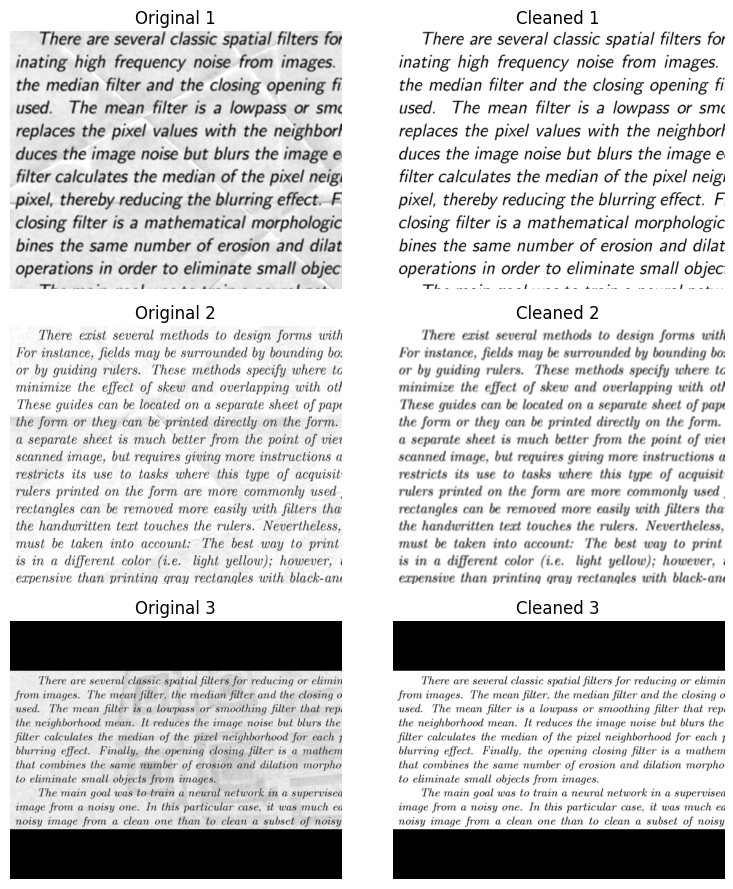

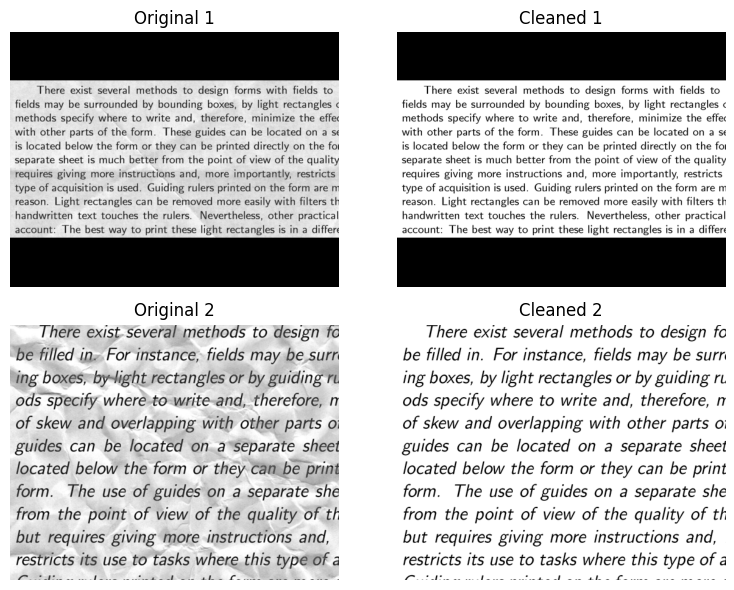

In [22]:
def visualize_paired_dataset(paired_loader, num_images=5):
    # paired_loader에서 데이터 하나 가져오기
    for train_images, cleaned_images in paired_loader:
        # 시각화
        fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 3))  # num_images 행, 2열 (위: train, 아래: cleaned)
        for i in range(num_images):
            # 첫 번째 열: 원본 이미지 (train)
            axes[i, 0].imshow(train_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')  # [C, H, W] -> [H, W, C]
            axes[i, 0].set_title(f"Original {i+1}")
            axes[i, 0].axis('off')  # 축 비활성화

            # 두 번째 열: 정제된 이미지 (cleaned)
            axes[i, 1].imshow(cleaned_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')  # [C, H, W] -> [H, W, C]
            axes[i, 1].set_title(f"Cleaned {i+1}")
            axes[i, 1].axis('off')  # 축 비활성화

        plt.tight_layout()
        plt.show()
        break  # 한 번만 실행하도록 break

# PairedImageDataset에서 이미지 위아래 시각화
visualize_paired_dataset(train_loader, num_images=3)
visualize_paired_dataset(val_loader, num_images=2)


In [23]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [24]:
# AutoEncoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        # Depthwise + Pointwise
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, groups=1, bias=False),
            nn.Conv2d(1, 8, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (8, 210, 270)
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1, groups=1, bias=False),
            nn.Conv2d(8, 16, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (16, 105, 135)
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (32, 52, 67)
        )

        # 
        self.enc4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=1, bias=False),
            nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (64, 26, 33)
        )

        self.enc5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=1, bias=False),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (128, 13, 16)
        )

        # Decoder
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1, bias=False),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, bias=False),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1, groups=32, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=1, stride=1, bias=False),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1, groups=16, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=1, stride=1, bias=False),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1, groups=8, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(8, 1, kernel_size=1, stride=1, bias=False),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=1, output_padding=1, groups=1, bias=False),
            nn.Sigmoid()  # 픽셀 값을 0~1로 정규화
        )

        # Skip Connection 채널 맞추기
        self.conv4 = nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False)  # (64 → 32)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=False)  # (128 → 64)
    
    def forward(self, x):
        # Encoding
        enc1_out = self.enc1(x)  # (8, 210, 270)
        enc2_out = self.enc2(enc1_out)  # (16, 105, 135)
        enc3_out = self.enc3(enc2_out)  # (32, 52, 67)
        enc4_out = self.enc4(enc3_out)  # (64, 26, 33)
        enc5_out = self.enc5(enc4_out)  # (128, 13, 16)

        # Decoding with Skip Connection
        dec5_out = self.dec5(enc5_out)  # (64, 26, 33)
        dec5_out = F.interpolate(dec5_out, size=(26, 33), mode='bilinear', align_corners=False)
        dec5_out = torch.cat([dec5_out, enc4_out], dim=1)
        dec5_out = self.conv5(dec5_out)  # (128 → 64)

        dec4_out = self.dec4(enc4_out)  # (32, 52, 67)
        dec4_out = F.interpolate(dec4_out, size=(52, 67), mode='bilinear', align_corners=False)
        dec4_out = torch.cat([dec4_out, enc3_out], dim=1)  # Skip Connection
        dec4_out = self.conv4(dec4_out)  # (64 → 32)

        dec3_out = self.dec3(dec4_out)  # (16, 104, 134)
        dec3_out = F.interpolate(dec3_out, size=(105, 135), mode='bilinear', align_corners=False)

        dec2_out = self.dec2(dec3_out)  # (8, 210, 270)
        dec2_out = F.interpolate(dec2_out, size=(210, 270), mode='bilinear', align_corners=False)

        dec1_out = self.dec1(dec2_out)  # (1, 420, 540)
        dec1_out = F.interpolate(dec1_out, size=(420, 540), mode='bilinear', align_corners=False)

        # Output
        outputs = torch.clamp(dec1_out, min=0.001, max=0.999)
        return outputs

model = DenoisingAutoencoder().to(device)


In [25]:
summary(model, input_size=(16, 1, 420, 540), device=device)


Layer (type:depth-idx)                   Output Shape              Param #
DenoisingAutoencoder                     [16, 1, 420, 540]         --
├─Sequential: 1-1                        [16, 8, 210, 270]         --
│    └─Conv2d: 2-1                       [16, 1, 420, 540]         9
│    └─Conv2d: 2-2                       [16, 8, 420, 540]         8
│    └─BatchNorm2d: 2-3                  [16, 8, 420, 540]         16
│    └─ReLU: 2-4                         [16, 8, 420, 540]         --
│    └─MaxPool2d: 2-5                    [16, 8, 210, 270]         --
├─Sequential: 1-2                        [16, 16, 105, 135]        --
│    └─Conv2d: 2-6                       [16, 8, 210, 270]         576
│    └─Conv2d: 2-7                       [16, 16, 210, 270]        128
│    └─BatchNorm2d: 2-8                  [16, 16, 210, 270]        32
│    └─ReLU: 2-9                         [16, 16, 210, 270]        --
│    └─Dropout: 2-10                     [16, 16, 210, 270]        --
│    └─MaxPool2

In [26]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, target):
        return torch.sqrt(F.mse_loss(pred, target))


In [27]:
class HybridLoss(nn.Module):
    def __init__(self, lambda_rmse=0.8, lambda_l1=0.2):
        super(HybridLoss, self).__init__()
        self.lambda_rmse = lambda_rmse
        self.lambda_l1 = lambda_l1
        self.rmse_loss = RMSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, pred, target):
        return self.lambda_rmse * self.rmse_loss(pred, target) + self.lambda_l1 * self.l1_loss(pred, target)


In [28]:
# 모델 설정
criterion = HybridLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)     # 스케쥴러가 적용될 것을 감안해 0.01부터 시작
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


In [29]:
# 기본 설정
epochs = 1000  # 최대 학습 에포크 수
patience = 5  # 몇 번 연속 val_loss가 증가하면 멈출지
early_stop_counter = 0  # Early Stopping 카운터
best_val_loss = float('inf')  # 초기 Best Loss를 매우 큰 값으로 설정
best_model_state = None  # Best 모델의 가중치를 저장할 변수

epoch = 0
while epoch  epochs:
    # train
    model.train()
    train_loss = 0.0
    train_rmse_loss = 0.0
    for train_images, train_cleaned_images in train_loader:
        train_images, train_cleaned_images = train_images.to(device), train_cleaned_images.to(device)
        optimizer.zero_grad()
        outputs = model(train_images)
        loss = criterion(outputs, train_cleaned_images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_rmse_loss += RMSELoss()(outputs, train_cleaned_images).item()  # RMSE 계산

    train_loss /= len(train_loader)
    train_rmse_loss /= len(train_loader)  # 평균 RMSE 계산
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, RMSE Score : {train_rmse_loss:.4f}")

    # validation
    model.eval()
    val_loss = 0.0
    val_rmse_loss = 0.0
    with torch.no_grad():
        for val_images, val_cleaned_images in val_loader:
            val_images, val_cleaned_images = val_images.to(device), val_cleaned_images.to(device)
            outputs = model(val_images)
            loss = criterion(outputs, val_cleaned_images)
            val_loss += loss.item()
            val_rmse_loss += RMSELoss()(outputs, val_cleaned_images).item()  # RMSE 계산

    val_loss /= len(val_loader)  # 평균 Loss 계산
    val_rmse_loss /= len(val_loader)  # 평균 RMSE 계산

    # 스케쥴러 적용
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # 러닝 레이트 변경시
    if current_lr != prev_lr:
        print(f"Learning Rate updated: {current_lr:.6f}\n")

    # Best model
    if val_loss  best_val_loss:
        print(f"New best validation loss: {val_loss:.4f} (Previous: {best_val_loss:.4f}), RMSE Score : {val_rmse_loss:.4f}")
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Validation loss increased! Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"Early stopping triggered! after {epoch+1} epochs")
        model.load_state_dict(best_model_state)
        print(f"Best model loaded with val_loss = {best_val_loss:.4f}")
        break

    epoch += 1

# Best model saved
if best_model_state is not None:  # Best 모델 저장
    torch.save(best_model_state, "best_model.pth")
    print(f"Best model saved with val_loss = {best_val_loss:.4f}")
else:
    print("No best model was saved.")


SyntaxError: invalid syntax (2277271753.py, line 9)

In [30]:
# Best Model 불러오기
best_model_path = "best_model.pth"  # 저장된 모델 경로
model.load_state_dict(torch.load(best_model_path))  # Best Model 불러오기

# 테스트
model.eval()  # 평가 모드
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        outputs = model(images) # 출력
        break


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [31]:
def visualize_images_and_outputs(images, outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """
    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))  # num_images 행, 2열

    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original {i + 1}", fontsize=10)
        axes[i, 0].axis('off')

        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, outputs)


NameError: name 'images' is not defined

In [32]:
test_dir = "/content/denoising_data/test"
test_dir


'/content/denoising_data/test'

In [33]:
# Best Model 불러오기
best_model_path = "best_model.pth"  # 저장된 모델 경로
model.load_state_dict(torch.load(best_model_path))  # Best Model 불러오기

model.eval()
all_outputs = []  # 예측 결과를 저장할 리스트
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)  # outputs의 shape: (batch_size, 1, 420, 540)
        all_outputs.append(outputs.cpu())

# 모든 배치의 결과를 하나의 텐서로 결합
all_outputs = torch.cat(all_outputs, dim=0)
print("all_outputs shape:", all_outputs.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [34]:
import os
import csv
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF  # 원래 패딩 적용에 사용한 함수

# ---------------------------------------------------------------------------------
# 전제 조건:
# - test_dir: 테스트 이미지가 저장된 폴더 경로 (이미 정의되어 있음)
# - all_outputs: 모델 예측 결과가 순서대로 저장된 리스트 또는 텐서
#                각 예측 결과는 (1, 420, 540) 크기의 텐서라고 가정
# ---------------------------------------------------------------------------------

# 학습 시 사용한 패딩 대상 크기 (PadToSize 클래스에서 사용한 target_size)
target_size = (420, 540)  # (높이, 너비)

# ---------------------------------------------------------------------------------
# 원래 PadToSize 클래스에서 사용한 패딩 계산 로직
# 원본 이미지에 대해 좌우 및 상하 패딩을 어떻게 적용했는지 계산하는 함수입니다.
# ---------------------------------------------------------------------------------
def compute_padding(orig_size, target_size):
    """
    원본 이미지 크기(orig_size)를 target_size로 패딩했을 때 추가된 패딩 값을 계산합니다.
    :param orig_size: (높이, 너비) 튜플 (원본 이미지 크기)
    :param target_size: (높이, 너비) 튜플 (패딩이 적용된 크기)
    :return: (pad_top, pad_bottom, pad_left, pad_right)
    """
    orig_height, orig_width = orig_size
    target_height, target_width = target_size
    # 상단 패딩 계산: 원본 높이가 target보다 작을 때만 패딩 적용
    pad_top = (target_height - orig_height) // 2 if target_height > orig_height else 0
    # 하단 패딩: 전체 패딩에서 상단 패딩을 뺀 나머지
    pad_bottom = target_height - orig_height - pad_top if target_height > orig_height else 0
    # 좌측 패딩 계산
    pad_left = (target_width - orig_width) // 2 if target_width > orig_width else 0
    # 우측 패딩 계산
    pad_right = target_width - orig_width - pad_left if target_width > orig_width else 0
    return pad_top, pad_bottom, pad_left, pad_right

# ---------------------------------------------------------------------------------
# 모델 예측 결과에서 원본 영역(패딩이 제거된 영역)만 추출하는 함수
# ---------------------------------------------------------------------------------
def remove_padding(pred, orig_size, target_size):
    """
    모델 출력(pred)에서 원본 이미지 영역만 크롭합니다.
    :param pred: 모델 예측 결과 텐서, shape: (C, target_height, target_width)
    :param orig_size: 원본 이미지 크기 (높이, 너비)
    :param target_size: 패딩 적용된 크기 (높이, 너비)
    :return: 패딩이 제거된 텐서 (원본 영역만), shape: (C, orig_height, orig_width)
    """
    orig_height, orig_width = orig_size
    # 위에서 정의한 compute_padding 함수를 이용하여, 상단 및 좌측 패딩 값을 구함
    pad_top, _, pad_left, _ = compute_padding(orig_size, target_size)
    # pred 텐서에서, (채널, target_height, target_width) 중 원본 영역만 크롭
    return pred[:, pad_top:pad_top+orig_height, pad_left:pad_left+orig_width]

# ---------------------------------------------------------------------------------
# 테스트 이미지 파일 목록 생성 (파일 이름이 숫자로 되어 있다고 가정하고 정렬)
# ---------------------------------------------------------------------------------
test_file_paths = sorted(
    [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png')],
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

# CSV 제출 파일 생성을 위한 픽셀 id와 value를 저장할 리스트
submission_data = []

# ---------------------------------------------------------------------------------
# 각 테스트 이미지에 대해 순차적으로 처리
# ---------------------------------------------------------------------------------
# 여기서는 예시로 처음 30개의 이미지만 처리합니다.
for i in range(72):
    # i번째 파일 경로를 가져옴
    file_path = test_file_paths[i]
    # 파일명에서 이미지 id를 추출 (예: '1.png' -> '1')
    image_id = os.path.splitext(os.path.basename(file_path))[0]

    # PIL을 사용하여 원본 이미지 크기 읽기 (convert('L')로 그레이스케일 변환)
    orig_img = Image.open(file_path).convert('L')
    # PIL의 size는 (width, height) 순서이므로, 뒤집어 (높이, 너비)로 저장
    orig_width, orig_height = orig_img.size
    orig_size = (orig_height, orig_width)  # (높이, 너비)
    print("orig_size", orig_size)

    # ---------------------------------------------------------------------------------
    # 모델 예측 결과 가져오기
    # all_outputs는 모델 예측 결과가 순서대로 저장된 변수이며, 각 결과는 (1, 420, 540) 크기임
    # ---------------------------------------------------------------------------------
    idx = test_file_paths.index(file_path)
    pred = all_outputs[idx]  # shape: (1, 420, 540)

    # ---------------------------------------------------------------------------------
    # 원래 PadToSize 클래스와 동일한 로직을 사용해, 예측 결과에서 패딩 영역 제거 (크롭)
    # ---------------------------------------------------------------------------------
    cropped_pred = remove_padding(pred, orig_size, target_size)
    print('crop size', cropped_pred.shape)

    # ---------------------------------------------------------------------------------
    # 크롭된 결과 텐서를 numpy 배열로 변환 (채널 차원 제거하여 2D 배열로)
    # ---------------------------------------------------------------------------------
    pred_np = cropped_pred.squeeze(0).cpu().numpy()

    # ---------------------------------------------------------------------------------
    # 결과 이미지 확인: matplotlib를 사용해 크롭된(패딩 제거된) 이미지 출력
    # ---------------------------------------------------------------------------------
    plt.figure()
    plt.imshow(pred_np, cmap='gray')
    plt.title(f"{i}th Cropped Output for image {image_id}\n(Original height: {orig_height} width: {orig_width})")
    plt.axis('off')
    plt.show()

    # ---------------------------------------------------------------------------------
    # CSV 파일 제출을 위해, 크롭된 이미지를 픽셀 단위로 flatten
    # 각 픽셀의 id는 "imageID_row_col" 형식 (행과 열 번호는 1부터 시작)
    # ---------------------------------------------------------------------------------
    for row in range(orig_height):
        for col in range(orig_width):
            pixel_id = f"{image_id}_{row+1}_{col+1}"
            pixel_value = pred_np[row, col]
            submission_data.append((pixel_id, pixel_value))

# ---------------------------------------------------------------------------------
# 최종적으로 CSV 파일로 제출 데이터를 저장
# ---------------------------------------------------------------------------------
submission_file = 'submission.csv'
with open(submission_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "value"])  # CSV 헤더 작성
    for row in submission_data:
        writer.writerow(row)

print(f"Submission file '{submission_file}'이(가) 생성되었습니다.")


orig_size (258, 540)


NameError: name 'all_outputs' is not defined